In [ ]:
conda install cudatoolkit=10.2

In [ ]:
!rsync -a ../input/mmdetection-v280/mmdetection ../
!pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
!pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
!pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
!pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

In [ ]:
!pip install -r ../input/mmdetection-v280/mmdetection/requirements.txt

In [ ]:
from itertools import groupby
from pycocotools import mask as mutils
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [ ]:
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'    
ROOT = '../input/hpa-single-cell-image-classification/'
MAX_THRE = 4
train_or_test = 'train'

img_dir = f'../work/mmdet_v1_train'
!mkdir -p {img_dir}
df = pd.read_csv(os.path.join(ROOT, 'train.csv'))
# df = df[:100]

Coco_rle_encode dùng để encode binary masks thành rles format
với đầu vào là binary masks 2 chiều và đầu ra là dữ liệu rles format với mục đích giảm kích thước lưu trữ xuống.


In [ ]:
def coco_rle_encode(mask):
    '''
    implement storing binary masks by rles format (run-length format)
    input:
        mask: mask of image
    output:
        rle encode format
    '''
    rle = {'counts': [], 'size': list(mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [ ]:
l = get_rles_from_mask(num_sample.iloc[0])

thực hiện biểu diễn các mask của từng tế bào trong ảnh 

In [ ]:
def get_rles_from_mask(image_id):
    '''
    implement get rle of all masks in image
    input:
        image_id : id of image
    return:
        list of rle
        height of image
        width of image
    '''
    img = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    print (plt.imshow(img))
    rle_list = []
    for val in np.unique(img):
        if val == 0:
            continue
        binary_mask = np.where(img == val, val, 0).astype(bool)
        counts = []
        rle = coco_rle_encode(binary_mask)
        rle_list.append(rle)
    return rle_list, img.shape[0], img.shape[1]

thực hiện convert ảnh thành coco format dataset

In [ ]:
def mk_mmdet_custom_data(image_id):
    '''
    convert data to coco format
    input:
        image_id: id of image
    return:
        annotation json files in coco format
    '''
    rles, height, width = get_rles_from_mask(image_id)
    if len(rles) == 0:
        return {
            'filename': image_id+'.jpg',
            'width': width,
            'height': height,
            'ann': {}
        }
    rles = mutils.frPyObjects(rles, height, width)
    masks = mutils.decode(rles)
    bboxes = mutils.toBbox(mutils.encode(np.asfortranarray(masks.astype(np.uint8))))
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    return {
        'filename': image_id+'.jpg',
        'width': width,
        'height': height,
        'ann':
            {
                'bboxes': np.array(bboxes, dtype=np.float32),
                'labels': np.zeros(len(bboxes)),
                'masks': rles
            }
    }

Từ ID ảnh đầu vào thực hiện stack 3 kênh màu RGB lại với nhau

In [ ]:
def load_RGB_image(image_id, train_or_test='train', image_size=None):
    '''
    load image with each channels follow by stack them
    '''
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    # using rgb only here
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

thực hiện show ảnh gốc với 3 kênh màu RGB, mask của ảnh và mask + ảnh gốc

In [ ]:
def print_masked_img(image_id, mask):
    '''
    visualize image
    input:
        image_id: id of image
        mask: mask of image with above image_id
    '''
    img = load_RGB_image(image_id, train_or_test)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()

Thực hiện đọc ảnh, bằng opencv

In [ ]:
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

tạo ann cho ảnh

In [ ]:
def mk_ann(idx):
    '''
    get the annotation json files in coco format for each image
    input:
        idx
    output:
        anno: the annotation json
        image_id : id of image
    '''
    image_id = df.iloc[idx].ID
    anno = mk_mmdet_custom_data(image_id)
    img = load_RGB_image(image_id, train_or_test)
    cv2.imwrite(f'{img_dir}/{image_id}.jpg', img)
    return anno, idx, image_id

In [ ]:
num_sample

In [ ]:
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'    
for idx in range(3):
    image_id = df.iloc[idx].ID
    cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    print_masked_img(image_id, cell_mask)
    load_RGB_image(image_id)

lọc ra các id ảnh chỉ có 1 nhãn

In [ ]:
num_sample = df.ID.iloc[[idxx for idxx in range(len(df)) if '|' not in df['Label'].iloc[idxx]]]
len(list(num_sample))

lọc ra 1000 anno cho từng 1000 id ảnh 

In [ ]:
p = Pool(processes=MAX_THRE)
annos = []
c = 0
for i, (anno, idx, image_id) in enumerate(p.imap(mk_ann, range(len(df)))):
    if len(anno['ann']) > 0 and image_id in list(num_sample):
        annos.append(anno)
        c += 1
    if c % 100 == 0:
        print (idx, image_id)
    if c > 1000:
        break

split data (train:val) : (80:20)

In [ ]:
lbl_cnt_dict = df.set_index('ID').to_dict()['Label']
trn_annos = []
val_annos = []
val_len = int(len(annos)*20/100)
for idx in range(len(annos)):
    ann = annos[idx]
    filename = ann['filename'].replace('.jpg','').replace('.png','')
    label_id = lbl_cnt_dict[filename]
    if '|' not in label_id:
        label_id = int(label_id)
        ann['ann']['labels'] = np.full(len(ann['ann']['bboxes']), label_id)
        if idx < val_len:
            val_annos.append(ann)
        else:
            trn_annos.append(ann)

In [ ]:
print (len(trn_annos))
print (len(val_annos))

In [ ]:
with open(f'../work/mmdet_v1_full.pkl', 'wb') as f:
    pickle.dump(annos, f)
with open(f'../work/mmdet_v1_trn.pkl', 'wb') as f:
    pickle.dump(trn_annos, f)
with open(f'../work/mmdet_v1_val.pkl', 'wb') as f:
    pickle.dump(val_annos, f)

train
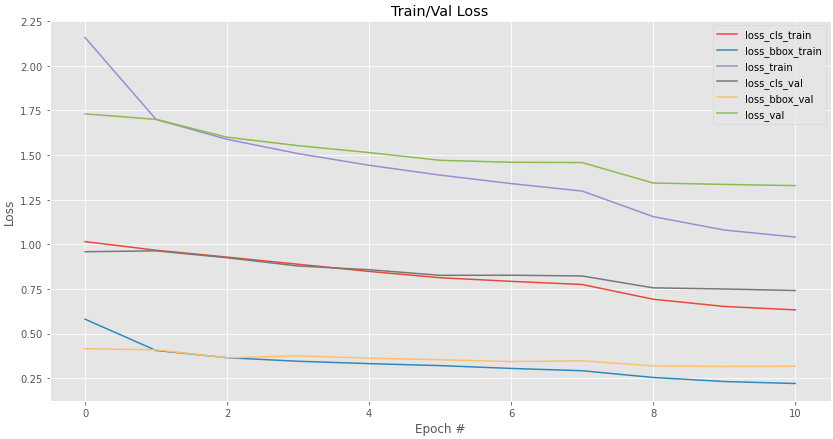

In [ ]:
# config = f'configs/hpa_{exp_name}/mask_rcnn_r50_fpn_1x_coco.py'
config = f'configs/mask_rcnn_unique/mask_rcnn_r50_fpn_1x_coco.py'

# using --no-validate to avoid some errors for custom dataset metrics
# additional_conf = '--no-validate '
additional_conf = ' --cfg-options workflow="[(train,1),(val,1)]"'
additional_conf += f' --cfg-options optimizer.lr=0.0025'
additional_conf += f' --cfg-options work_dir=../working/work_dir'
additional_conf += f' --cfg-options load_from=../input/mmdetection-v280/pretrained/mask_rcnn_r50_fpn_2x_coco_bbox_mAP-0.392__segm_mAP-0.354_20200505_003907-3e542a40.pth'
cmd = f'bash -x tools/dist_train.sh {config} 1 {additional_conf}'
!cd ../mmdetection; {cmd}

In [ ]:
from pycocotools import _mask as coco_mask
import matplotlib.pyplot as plt
import os
import base64
import typing as t
import zlib
import random
random.seed(0)

exp_name = "mmdet_v1"
image_size = None
ROOT = '../input/hpa-single-cell-image-classification/'
train_or_test = 'test'
df = pd.read_csv(os.path.join(ROOT, 'sample_submission.csv'))

tạo annotate cho dữ liệu test

In [ ]:
out_image_dir = f'../work/mmdet_v1_test/'
!mkdir -p {out_image_dir}

annos = []
for idx in tqdm(range(len(df))):
    image_id = df.iloc[idx].ID
    img = load_RGB_image(image_id, train_or_test, image_size)
    
    cv2.imwrite(f'{out_image_dir}/{image_id}.jpg', img)
    ann = {
        'filename': image_id+'.jpg',
        'width': img.shape[1],
        'height': img.shape[0],
        'ann': {
            'bboxes': None,
            'labels': None,
            'masks': None
        }
    }
    annos.append(ann)
    
with open(f'../work/mmdet_v1_tst.pkl', 'wb') as f:
    pickle.dump(annos, f)

In [ ]:
# I just made following config files based on default mask_rcnn.
# Other than that, I used it as is for mmdetection.
!ls -l ../mmdetection/configs/mask_rcnn_unique/

In [ ]:
# from distutils.dir_util import copy_tree

In [ ]:
# copy_tree('../mmdetection/work_dirs/mask_rcnn_r50_fpn_1x_coco', './')

In [ ]:
config = 'configs/mask_rcnn_unique/mask_rcnn_r50_fpn_1x_coco.py'
model_file = './epoch_10.pth'
result_pkl = '../work/mask_rcnn_r50_fpn_1x_epoch_10.pkl'
cmd = f'python tools/test.py {config} {model_file} --out {result_pkl}'
!cd ../mmdetection; {cmd}
result = pickle.load(open('../mmdetection/'+result_pkl, 'rb'))

In [ ]:
for ii in range(3):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    for class_id in range(19):
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for bb, sg in zip(bbs,sgs):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][0]
            if cnf > 0.3:
                print(f'class_id:{class_id}, image_id:{image_id}, confidence:{cnf}')
                mask = mutils.decode(sg).astype(bool)
                print_masked_img(image_id, mask)